# Team Park Rangers: Forest Classification Kaggle Competition

## Patrick Barranger, Zach Day, and Zhaoning Yu 
### W207 Section 4, Spring 2018

In [3]:
import math
import csv
import time
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.cm as cm

from matplotlib.ticker import MultipleLocator
from pprint import pprint

from sklearn.preprocessing import FunctionTransformer, StandardScaler, Imputer, MinMaxScaler, Normalizer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import f1_score, classification_report, confusion_matrix, roc_auc_score, accuracy_score
from sklearn import metrics, cross_validation
from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier

import warnings 
warnings.filterwarnings('ignore')

%matplotlib inline

## 1. Business Understanding (PKB)

Our goal for this project is to predict tree classification based on cartographic data. Specifically we need to specify one of seven possible classifications, and we measured success based on multi-class classification accuracy. Our data come from the US Forest Service & Geological Survey Data for Roosevelt National Forest. Our deliverable is an optimized model for tree classification the results in timely and accurate results. 
    

## 2. Exploratory Data Analysis

### 2.1 Load Data

We first load the data and split the data into a training and a test data.

The we split the labeled raining data into a training set (df_train) and a test set (df_test).

We note there are **15120** labeled observations in the training data, and there are **565892** unlabeled observations in the test data. The relatively small size (**~2.7%**) of the labeled training data compared to size of the unlabeled test data poses a challenge for the generalization of any trained models.

In [30]:
data_train = pd.read_csv('train.csv')             # read training data
data_test = pd.read_csv('test.csv')

df_train, df_test = train_test_split(data_train, random_state=1)

print(data_train.shape)
print(data_test.shape)
print(df_train.shape)
print(df_test.shape)

(15120, 56)
(565892, 55)
(11340, 56)
(3780, 56)


### 2.2 Data Description

The study area includes four wilderness areas located in the Roosevelt National Forest of northern Colorado. The forest cover type was determined from US Forest Service (USFS) Region 2 Resource Information System data. Independent variables were derived from data obtained from the US Geological Survey and USFS.

Each row represents the actual forest cover type for a given $30 \times 30$ meter patch. 

####  2.2.1 The Target 

The target is the **Cover_Type** feature, the seven cover types are:

- **1** - Spruce/Fir

- **2** - Lodhepole Pine

- **3** - Ponderosa Pine

- **4** - Cottonwood/Willow

- **5** - Aspen

- **6** - Douglas-fir

- **7** - Krummholz

#### 2.2.2 The Predictive Features

The dataset includes the following feature columns:

- **Elevation** - Elevation in meters

- **Aspect** - Aspect in degrees azimuth

- **Slope** - Slope in degrees

- **Horizontal_Distance_To_Hydrology** - Horz Dist to nearest surface water features

- **Vertical_Distance_To_Hydrology** - Vert Dist to nearest surface water features

- **Horizontal_Distance_To_Roadways** - Horz Dist to nearest roadway

- **Hillshade_9am** (0 to 255 index) - Hillshade index at 9am, summer solstice

- **Hillshade_Noon** (0 to 255 index) - Hillshade index at noon, summer solstice

- **Hillshade_3pm** (0 to 255 index) - Hillshade index at 3pm, summer solstice

- **Horizontal_Distance_To_Fire_Points** - Horz Dist to nearest wildfire ignition points

- **Wilderness_Area** (4 binary columns, 0 = absence or 1 = presence) - Wilderness area designation

- **Soil_Type** (40 binary columns, 0 = absence or 1 = presence) - Soil Type designation

#### 2.2.3 Create Lists of Features Names for Effective Flitering

In [6]:
# target name is "Cover_Type" 
target = df_train.columns[-1]                  # "Cover_Type": target feature         

# remove "ID" column - it is an index and not a feature
all_features_ALL = df_train.columns[1:-1]      # "all_features_ALL": names of all features 

# seperate features by data type  
num_features = df_train.columns[1:11]          #  "num_features": names of all numerical features                    
cat_features_ALL = df_train.columns[11:-1]     #  "cat_features": names of all categorical features

#seperate binary features by classification covered
wild_features = df_train.columns[11:15]        # "wild_features": names of all 4 wilderness areas
soil_features_ALL = df_train.columns[15:-1]    # "soil_features_ALL": names of all soil types

### 2.3  Summary Statistics

- There are no missing values in the data set - every row can be used.
- The **Vertical_Distance_To_Hydrology** feature has some negative values.
- The **Wilderness_Area** and **Soil_Type** features are one-hot encoded
- The **Soil_Type7** and **Soil_Type15** features can be removed as they are constant (all zeros)
- Scales are not the same for all, rescaling and standardization may be helpful for some algorithms.

#### 2.3.1 Target Class Distribution

- all classes have the same number, no class-rebalancing is necessary

In [7]:
df_train.groupby('Cover_Type').size()

Cover_Type
1    1608
2    1599
3    1630
4    1597
5    1647
6    1631
7    1628
dtype: int64

#### 2.3.2 Numerical Features Summary

In [6]:
# summary statistics of numerical features
df_train[num_features].describe().T

,count,mean,std,min,25%,50%,75%,max
Elevation,11340.0,2749.620723,417.808200,1863.0,2376.0,2751.0,3103.0,3846.0
Aspect,11340.0,156.266138,110.192472,0.0,64.0,124.0,260.0,360.0
Slope,11340.0,16.502557,8.441615,0.0,10.0,15.0,22.0,49.0
Horizontal_Distance_To_Hydrology,11340.0,227.047707,209.623473,0.0,67.0,180.0,324.0,1343.0
Vertical_Distance_To_Hydrology,11340.0,51.372840,61.590572,-134.0,5.0,33.0,80.0,554.0
Horizontal_Distance_To_Roadways,11340.0,1705.479894,1318.869380,0.0,752.0,1315.0,2260.0,6890.0
Hillshade_9am,11340.0,212.800088,30.313149,58.0,196.0,220.0,235.0,254.0
Hillshade_Noon,11340.0,218.867549,22.916015,99.0,207.0,223.0,235.0,254.0
Hillshade_3pm,11340.0,134.902910,46.017597,0.0,106.0,138.0,167.0,248.0
Horizontal_Distance_To_Fire_Points,11340.0,1505.621164,1094.225093,0.0,726.0,1249.0,1975.0,6993.0


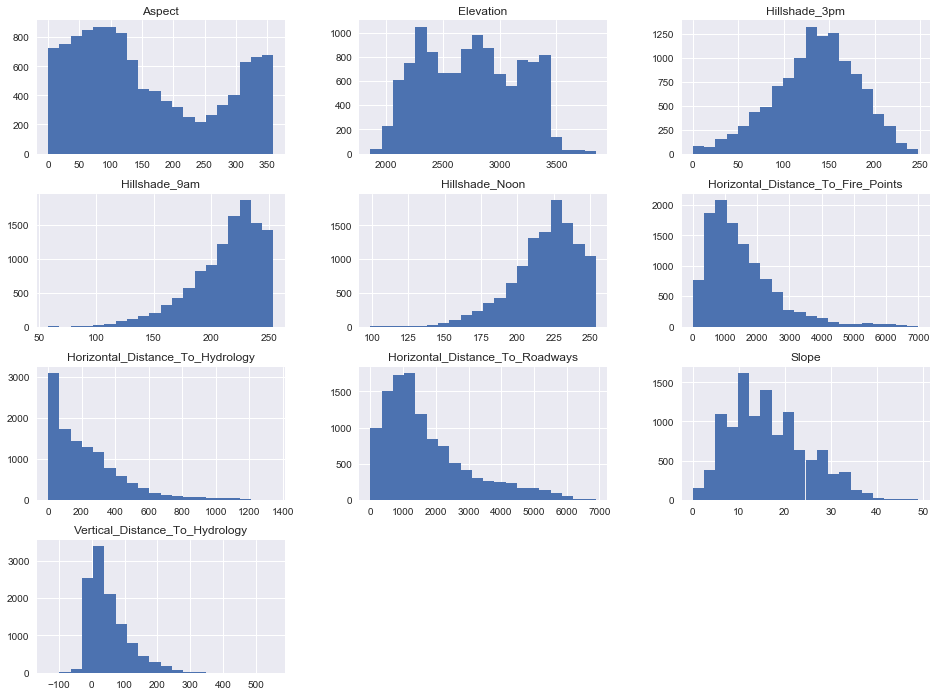

In [7]:
# histograms of numerical features
df_train[num_features].hist(figsize=(16,12), bins=20)
plt.show()

### 2.4 Feature Correlations

Strong correlations observed between between the following pairs of features (potential opportunity to reduce the number of features):

- *Hillshade_9am & Hillshade_3pm* = -0.78
- *Horizontal_Distance_To_Hydrology & Vertical_Distance_To_Hydrology* = 0.65
- *Aspect & Hillshade_3pm* = 0.64
- *Hillshade_Noon & Hillshade_3pm* = 0.61
- *Slope & Hillshade_Noon* = -0.61
- *Aspect & Hillshade_9am* = -0.59
- *Elevation & Horizontal_Distance_To_Roadways* = 0.58

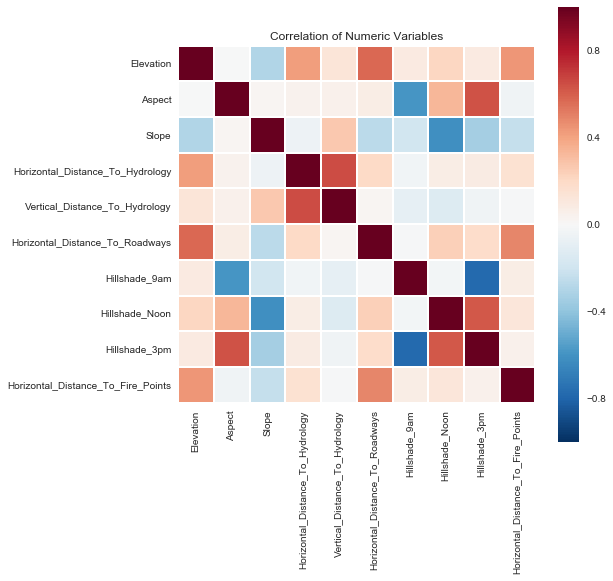

In [8]:
size = num_features.shape[0]         # size: 10 numeric features
num_data = df_train[num_features]    #  selecting numeric features
num_data_cor = num_data.corr()       # correlation matrix

# correlation heat map
fig, ax = plt.subplots(figsize=(8, 8))  
sns.heatmap(num_data_cor, square=True, linewidths=1)
plt.title('Correlation of Numeric Variables')
plt.show()

### 2.5 Cover Type Dependence on Features

#### 2.5.1 Cover Type Dependence on Numerical Features

- The **Elevation** is the feature with the most predictive power.

- When the Cover Types are presented in scatterplots, we observe clustering of Cover Types from the differences in  Elevation.

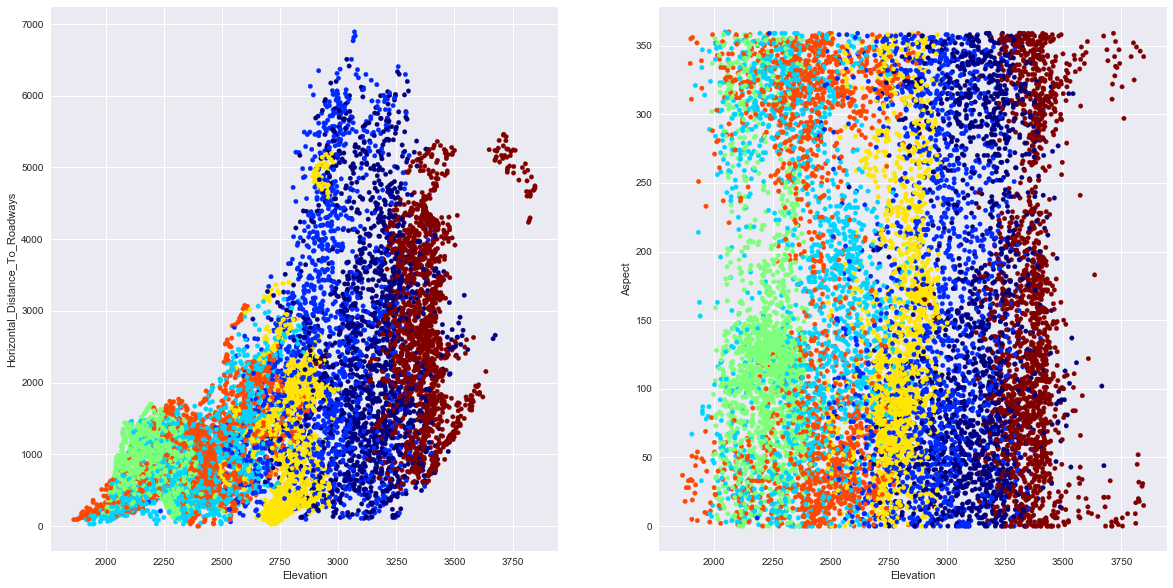

In [9]:
cmap = cm.jet

labels = df_train.Cover_Type

fig, axes = plt.subplots(1, 2, figsize=(20,10))

df_train.plot(kind='scatter', x='Elevation', y='Horizontal_Distance_To_Roadways',
              marker='o', c=labels, cmap=cmap, colorbar=False, ax=axes[0])

df_train.plot(kind='scatter', x='Elevation', y='Aspect', 
              marker='o', c=labels, cmap=cmap, colorbar=False, ax=axes[1])

plt.show()

#### 2.5.2 Cover Type Dependence on Categorical Features - Wilderness Areas

- Cover_Type **4** is only found in Wilderness Area 4 - it turns out that the **Wilderness_Area4** is also the one with the most predictive power among the four "Wilderness Area" features;

- There are relatively fewer observations in Wilderness Area 2 - it turns out that the **Wilderness_Area2** is also the one with the least predictive power among the four "Wilderness Area" features;


Number of Observations for Each Wildeness Area:

Wilderness_Area1: 2672
Wilderness_Area2: 374
Wilderness_Area3: 4793
Wilderness_Area4: 3501


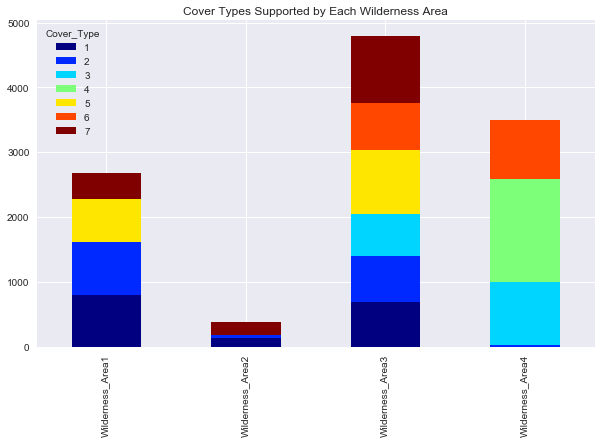

In [10]:
# Q1: Which Cover Types are Supported by Each Wilderness Area?

col_names = df_train.columns.tolist()

A = np.array(col_names)

soil_types = [item for item in A if "Soil" in item]                    # names of all soil types
wilderness_areas = [item for item in A if "Wilderness_Area" in item]   # names of all wilderness areas

# display number of observations for each Wilderness Area:
print("\nNumber of Observations for Each Wildeness Area:\n")
for wilderness_area in wilderness_areas: print(wilderness_area + ":", df_train[wilderness_area].sum())

# barplot showing the Cover_Types supported by Each Wilderness Area:    
wild_areas_sum = df_train[wilderness_areas].groupby(df_train['Cover_Type']).sum()   # counting cover types
wild_areas_sum.T.plot(kind='bar', stacked=True, figsize=(10,6), cmap='jet')         # barplot
plt.title("Cover Types Supported by Each Wilderness Area")
plt.show()    

#### 2.5.3 Cover Type Dependence on Categorical Features - Soil Types

- The Soil Types **10, 38, 3, 39** have more predictive power - each of these Soil Type features has one dominant Cover Type in it.

- The Soil Types with a small number of observations (such as Soil Types **8, 25, 28, 36**) are the ones with the least predictive power.

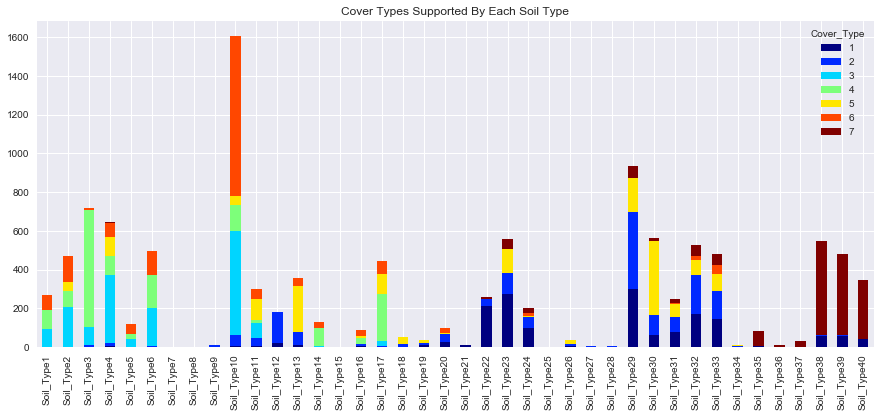

In [11]:
# Q2: Which soil_types support which cover_types?
types_sum = df_train[soil_types].groupby(df_train['Cover_Type']).sum()   # counting cover types
types_sum.T.plot(kind='bar', stacked=True, figsize=(15,6), cmap='jet')   # barplot
plt.title("Cover Types Supported By Each Soil Type")
plt.show()

### 2.6 Feature Importance

To explore the relative importance of different features for prediction, we tentatively fit a random forest classifier using the training data and plot out the importance for different features:

- **Elevation** and **Horizontal_Distance_To_Roadways** are the two most important features.

- **Wilderness_Area4** and **Soil_Type38** are the two most important categorical features.

- **"Id"** is ranked the 2nd in importance, but note this is just an index, not a feature. **"Id" should be removed** from the the list of predictive features, otherwise it will distort the prediction results.

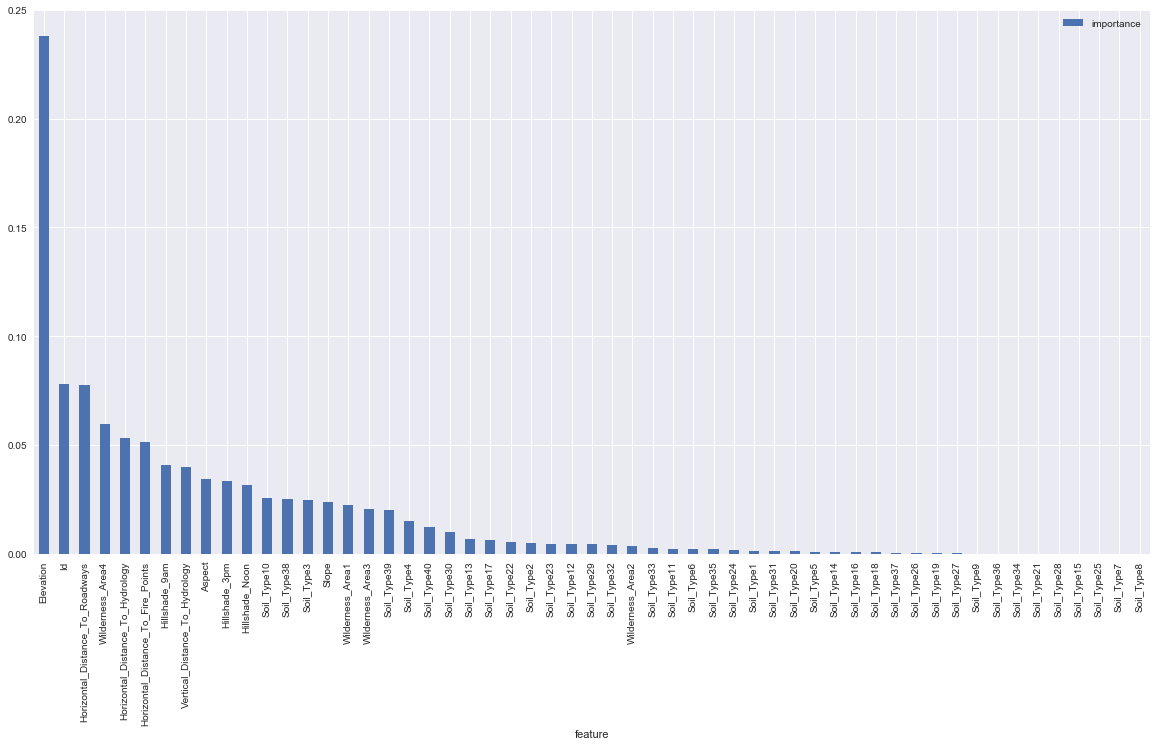

In [13]:
# 1: Split the df_train into a training set and a dev set
X_train, X_dev, Y_train, Y_dev = train_test_split(df_train.drop('Cover_Type',axis=1),
                                                df_train['Cover_Type'], test_size=0.2)

# 2: Try random forest.
rf_clf = RandomForestClassifier(n_estimators = 300, max_depth=15,min_samples_leaf=2)
rf_clf.fit(X_train, Y_train)

# 3: Get feature importance and plot results
predictors = df_train.columns[:-1]

importance_df = pd.DataFrame({
    'feature': predictors,
    'importance': rf_clf.feature_importances_
})

importance_df.sort_values(by='importance', 
                          ascending=False).plot(x='feature', y='importance', kind='bar', figsize=(20,10))
plt.show()

## 3. Data Preparation

To prepare data for modeling:

- We first remove columns "**Id**", "**Soil_Type7**", "**Soil_Type15**" since they do not cotain useful information. We use all the remaining features for the final modeling. However, for testing purposes, we also create lists of the most important 17, 10, 5, 2 features based on the results of EDA.

- We create two functions "**get_num_features()**" and "**get_cat_features()**" that separate the numerical and categorical features for a list of features.

- For the data preprocessing, we create a pipeline which first separate the data into numerical and categorical features, then we apply **standard scaling** to the numerical features while leaving the categorical features intact. Finally, both the scaled numerical features and categorical features are combined for the modeling. 

### 3.1 Define Lists of Features to be Used for Modeling

In [11]:
# STEP 1: remove constant Soil_Type7 and Soil_Type15 because they do not have data
all_features = all_features_ALL.drop(['Soil_Type7', 'Soil_Type15'])

cat_features = cat_features_ALL.drop(['Soil_Type7', 'Soil_Type15'])
soil_features = soil_features_ALL.drop(['Soil_Type7', 'Soil_Type15'])

# STEP 2: create lists of the most important 17, 10, 5, 2 features
top17_features = all_features_ALL[[0,5,9,13,3,4,6,1,8,7,23,51,16,2,52,10,12]]
top10_features = all_features_ALL[[0,5,9,13,3,4,6,1,8,7]]
top5_features = all_features_ALL[[0,5,9,13,3]]
top2_features = all_features_ALL[[0,5]]

### 3.2 Define the Data Preprocessing Pipeline

In [12]:
# STEP 1: Define functions for separating features #########################################
def get_num_features(features):
    """To extract numerical features from a list of features"""
    num_features = [item for item in features if 'Soil' not in item and 'Wilderness' not in item ]
    return num_features

def get_cat_features(features):
    """To extract categorical features from a list of features"""
    cat_features = [item for item in features if 'Soil' in item or 'Wilderness' in item ]
    return cat_features

# STEP 2: Select the features to be used for modeling ######################################
features = all_features                     # all features used in final modeling
                                            # we also tested using top 17, 10, 5, 2 features 

num_features = get_num_features(features)   # names of numerical features
cat_features = get_cat_features(features)   # names of categorical features

def select_num_features(X):
    """extract numerical data from a dataframe"""
    return X[num_features]

def select_cat_features(X):
    """extract categorical data from a dataframe"""
    return X[cat_features]

# STEP 3: Preporcess numerical and categorical features separately ########################
num_feature_pipeline = Pipeline(steps=[
    ('select', FunctionTransformer(select_num_features, validate=False)),
    ('scale', StandardScaler())
])

cat_feature_pipeline = Pipeline(steps=[
    ('select', FunctionTransformer(select_cat_features, validate=False) )    
])

# STEP 4: Combine numerical and categorical data ##########################################
fu = FeatureUnion([
    ('numeric', num_feature_pipeline),
    ('categorical', cat_feature_pipeline)
])

## 4. Modeling

- What model are we using? Why?
- Assumptions?
- Regularization?

### 4.1 Logistic Regression (PKB)

We started by modeling a logistic regression because of easy user comprehension. Out of the bag our LR model had 45% accuracy. We tested multiple C values via cross-validation, determining that C=2 provided the best accuracy. Our next step was to regularized the data via a standard scalar which raised our accuracy to 56%. Finally we used PCA in an attempt to limit the number of variable used. Ultimately it was determined that the best perfomring model contained all dimension that had data. Again, multiple C values were tested but C=2 continued toprovidethe best results. All in, our LR base model with regularized data and with a PCA transform resulted in a **56.03%** accuracy as reported from Kaggle. Given the postive (and better) results we were observing in other models we decided to stop any further work on the LR model.

In [16]:
#Base model with Standard Scalar
lr_pipe = Pipeline(steps=[
    ('preprocess', fu),
    ('predict', LogisticRegression(penalty='l2', C=2.0))
])

lr_pipe.fit(df_train, df_train[target])

y_pred_lr = lr_pipe.predict(df_test) 

Our testing indicated that 44 features were the optimum number of features, however our submissions to Kaggle ended up showing that al features provided the best results. 

0.6713
44


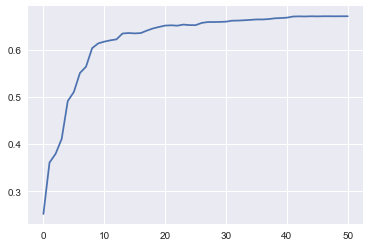

In [17]:
#Determine optimum number of features
def best_components(n_features):
    lr_pipe = Pipeline(steps=[
        ('preprocess', fu),
        ('pca', PCA(n_components= n_features)),
        ('predict', LogisticRegression(penalty='l2', C=2.0))
    ])

    lr_pipe.fit(df_train, df_train[target])
    
    scores_lr = cross_val_score(lr_pipe, df_train, df_train[target], cv=2)
    return scores_lr.mean().round(4)

out = [best_components(i) for i in range(1, 52)]

plt.plot(out)
print(np.max(out))
print(np.argmax(out))

In [18]:
#Based model with Standard Scalar and PCA
lr_pipe_pca = Pipeline(steps=[
    ('preprocess', fu),
    ('pca', PCA(n_components= 52)),
    ('predict', LogisticRegression(penalty='l2', C=2.0))
])

lr_pipe_pca.fit(df_train, df_train[target])

y_pred_lr_pca = lr_pipe_pca.predict(df_test)  # get predicted labels

### 4.2 KNN 
We have also tested the KNN model due to its simplicity and because the KNN model is very interpretable. The KNN model helps us to gain insight into ways for feature engineering that can improve performances for other models as well.

#### Feature Engineering for KNN:

For feature engineering, we have tried the following to improve our KNN classifier:

- **Feature filtering**: we have tested the KNN using all the features in the dataset, as well as a selected subset of the most important features (identified by a Random Forest classifier as discussed in Section 2 on EDA). We find that the best KNN performance is achieved by using **all features** available in the dataset.

- **Feature scaling**: we have found that **scaling** of the numerical features is the key for our KNN classifier performance, without it our Kaggle score for the test set is only **0.065**. 

- **Separate Numerical and Categorical Features**: Originally, we applied the StandardScaler to the whole dataset (the numerical features together with the categorical features) and we achieved a Kaggle score of **0.49** for KNN. Later, we separated the numerical from the categorical features in our preprocessing pipeline, by applying **StandardScaler to the numerical features only**, we have further improved our KNN Kaggle score to **0.69**.

- **PCA**: We have tried PCA to reduce the number of dimensions for the KNN ans we have found that **applying PCA decreases KNN accuracy** (generally by about 10 percentage points). For this reason, we do not use PCA in our final KNN classifier.

- **Removing irrelevant columns**: The data set has an "Id" column which is basically an index of the data rows. Originally we mistook "Id" as a feature and falsely used it to train our KNN model. As discussed in Setion 2 (EDA), if we do it this way, "Id" appears to be the second important feature next to "Elevation", which can confuse the KNN and lead to errorneous predictions. As a result, we remove the "Id" column before feeding the data to our final KNN model.

In addition, the insight we have gained through the KNN exercise helped us to improve other models as well. By applying the same KNN preprocessing pipeline to our best RandomForestClassifier, we have also improved the score of our RandomForestClassifier by **0.02** on Kaggle. 

#### Results for KNN:

By applying these feature engineering measures, we have achieved our highest Kaggle score of **0.6906** for KNN. 

In [19]:
# Our best KNN classifier
knn_num = 1

knn_pipe = Pipeline(steps=[
    ('preprocess', fu),
    ('predict', KNeighborsClassifier(n_neighbors = knn_num))
])

knn_pipe.fit(df_train, df_train[target])           # train KNN 

scores_knn = cross_val_score(knn_pipe, df_train, df_train[target], cv=5) # cross-validation
print("The KNN cross-validation score is: ", scores_knn.mean().round(4))                 

The KNN cross-validation score is:  0.7933


### 4.3 SVM 

By applying the same preprocessing pipeline, we have also tested the SVM classifier. 

The best performance is achieved by using a **Gaussian RBF Kernal** SVM with **gamma=0.1**, **C=1000**.

#### Results for SVM:

Our highest Kaggle sore for SVM is **0.72226**.


In [20]:
# Our best SVM classifier
svm_pipe = Pipeline(steps=[
    ('preprocess', fu),
    ('predict', SVC(kernel="rbf", gamma=0.1, C=1000))
])

svm_pipe.fit(df_train, df_train[target])            # train SVM

scores_svm = cross_val_score(svm_pipe, df_train, df_train[target], cv=5)   # cross-validation
print("The SVM cross-validation score is: ", scores_svm.mean().round(4))                 

The SVM cross-validation score is:  0.8116


### 4.4 RandomForest

We chose to test a RandomForestClassifier ensemble model on this classification problem for the following reasons:
- this ensemble model performs well with classification problems of this type
- cross validation and out of bag performance diagnostics can be used to quickly assess the predictive accuracy of the model
- very efficient hyperparameter tuning methods can be used to quickly drill-down to optimal hyperparameter settings
- same processing pipeline used for other models can be leveraged

**Optimal Hyperparameter Settings:**  
- max_depth = 35  
- max_features = 'sqrt'  
- max_leaf_nodes = None  
- min_impurity_decrease = 0.0  
- min_impurity_split = None  
- min_samples_leaf = 1  
- min_samples_split = 2  
- n_estimators = 400

**Results for RandomForest**  
Base Model (no feature engineering) Kaggle score: **0.717**  
Optimal Model Kaggle Score: **0.771**

In [8]:
# Instantiate a RandomForest object, fit to train data, produce predictions w/test data
rf = RandomForestClassifier()
rf.fit(data_train[all_features_ALL], data_train[target])
pred = rf.predict(data_test.iloc[:, 1:])

### 4.5 AdaBoost 

By applying the same preprocessing pipeline, we have also tested the AdaBoost classifier. 

The best performance is achieved by an AdaBoostClassifier using a DecisionTree with a **max_depth=15**, with **n_estimators=500**, **algorithm="SAMME.R"**, and **learning_rate=0.5**.

#### Results for AdaBoost:

Our highest Kaggle sore for AdaBoost is **0.77099** (the highest Kaggle score we have achieved for this dataset).


In [21]:
# Our best AdaBoost Classifier
ada_pipe = Pipeline(steps=[
    ('preprocess', fu),
    ('predict', AdaBoostClassifier(DecisionTreeClassifier(max_depth=15), 
                                   n_estimators=500, algorithm="SAMME.R", learning_rate=0.5))
])
    
ada_pipe.fit(df_train, df_train[target])                                      # train AdaBoost

scores_ada = cross_val_score(ada_pipe, df_train, df_train[target], cv=5)      # cross-validation
print("The AdaBoost cross-validation score is: ", scores_ada.mean().round(4))                 

The AdaBoost cross-validation score is:  0.8518


## 5. Evaluation

- How well does the model perform?
  - Accuracy
  - ROC curve does not apply in this case since ROC curve is strictly for binary classification
  - Cross-validation
  - other metrics? performance?

- AB test results (if any)

### 5.1 Logistic Regression (PKB)

LR models were tested with cross-validation before being submitted to Kaggle. Errors were analyzed via confusion matrixes. Errors seemed to be group similarly among tress who shared relative elevation (1&7) (1&2) (6&3).  

In [22]:
#base log F1
y_test = df_test[target]                # get correct labels
report_lr = classification_report(y_test, y_pred_lr)
print(report_lr)
#base log cross validation
scores_lr = cross_val_score(lr_pipe, df_train, df_train[target], cv=5)
print(scores_lr.round(4))
print(scores_lr.mean().round(4))

             precision    recall  f1-score   support

          1       0.63      0.63      0.63       552
          2       0.58      0.48      0.53       561
          3       0.61      0.56      0.59       530
          4       0.82      0.89      0.85       563
          5       0.61      0.70      0.65       513
          6       0.58      0.59      0.59       529
          7       0.87      0.86      0.87       532

avg / total       0.67      0.68      0.67      3780

[0.6693 0.6789 0.6755 0.6708 0.6614]
0.6712


In [23]:
#base log F1 Confusion Matrix 
y_pred_lr = lr_pipe.predict(df_test)
confusion_lr = confusion_matrix(y_test, y_pred_lr, labels=[1,2,3,4,5,6,7])
print(confusion_lr)

[[349  96   1   0  36   6  64]
 [128 269   9   0 126  24   5]
 [  0   2 297  71  15 145   0]
 [  0   0  30 503   0  30   0]
 [ 11  65  51   0 361  25   0]
 [  0  25  97  42  51 314   0]
 [ 66   5   0   0   2   0 459]]


In [24]:
# Train the lr_pipe and Make predictions ########################
lr_pipe.fit(data_train, data_train[target])

pred = lr_pipe.predict(data_test)
ID = data_test.Id

# Write to file for Kaggle Submission #############################
data_out = []
for i in range(len(ID)):
    data_out.append({'ID':ID.iloc[i], 'Cover_Type':pred[i]})

import csv
with open('base_log_model.csv', 'wt') as fout:
    cout = csv.DictWriter(fout, ['ID','Cover_Type'])
    cout.writeheader()
    cout.writerows(data_out)

In [25]:
#base log  + PCA F1
y_test = df_test[target]                # get correct labels
report_lr_pca = classification_report(y_test, y_pred_lr_pca)
print(report_lr_pca)
#base log + PCA cross validation
scores_lr_pca = cross_val_score(lr_pipe_pca, df_train, df_train[target], cv=5)
print(scores_lr_pca.round(4))
print(scores_lr_pca.mean().round(4))

             precision    recall  f1-score   support

          1       0.63      0.63      0.63       552
          2       0.58      0.48      0.53       561
          3       0.61      0.56      0.58       530
          4       0.82      0.89      0.85       563
          5       0.61      0.70      0.65       513
          6       0.58      0.59      0.59       529
          7       0.87      0.86      0.87       532

avg / total       0.67      0.67      0.67      3780

[0.6689 0.6793 0.675  0.6708 0.6614]
0.6711


In [26]:
#base log  + PCA F1 Confusion Matrix 
y_pred_lr_pca = lr_pipe_pca.predict(df_test)
confusion_lr_pca = confusion_matrix(y_test, y_pred_lr_pca, labels=[1,2,3,4,5,6,7])
print(confusion_lr_pca)

[[349  95   1   0  37   6  64]
 [128 269  10   0 126  23   5]
 [  0   2 293  69  15 151   0]
 [  0   0  31 500   0  32   0]
 [ 11  65  50   0 360  27   0]
 [  0  24  92  42  51 320   0]
 [ 66   5   0   0   2   0 459]]


In [27]:
# Train the lr_pipe and Make predictions ########################
lr_pipe_pca.fit(data_train, data_train[target])

pred = lr_pipe_pca.predict(data_test)
ID = data_test.Id

# Write to file for Kaggle Submission #############################
data_out = []
for i in range(len(ID)):
    data_out.append({'ID':ID.iloc[i], 'Cover_Type':pred[i]})

import csv
with open('pca_log_model.csv', 'wt') as fout:
    cout = csv.DictWriter(fout, ['ID','Cover_Type'])
    cout.writeheader()
    cout.writerows(data_out)

### 5.2 KNN

#### 5.2.1 Training and Test performance difference

Due to the much smaller size of the labeled training data (**15120**) compared to the test data (**565892**), we find it is a challenging to train a KNN model that generalize well on the test data. 

The Kaggle accuracy score we can achieve on the unlabeled test data is always about 10 percentage points lower than the accuracy score we obtain on the development data.

#### 5.2.2 Confusion Matrix and Error Analysis

The confusion matrix indicates the KNN classifier performs well for Cover Types 4 and 7. From the density plot shown below, Cover Type 4 is distributed at the low elevation, and Cover Type 7 is distributed at the high elevantion, and they are well separated from other Cover Types.

For Cover Types that are distributed at similar Elevations, it is more difficult to distinguish them, the KNN classifier makes more erroneous predictions. For example, there is a lot of overlap between Cover Types 3 and 6, and there is a lot of confusion between these two types in the confusion matrix. 


In [28]:
y_test = df_test[target]                # get correct labels
y_pred_knn = knn_pipe.predict(df_test)  # get predicted labels

confusion_knn = confusion_matrix(y_test, y_pred_knn, labels=[1,2,3,4,5,6,7])
print(confusion_knn)

[[382 106   0   0  16   1  47]
 [109 350   8   1  75  14   4]
 [  0  10 385  40   7  88   0]
 [  0   0  16 530   0  17   0]
 [  8   9  11   0 480   5   0]
 [  0   7  62  19  12 429   0]
 [ 17   3   0   0   0   0 512]]


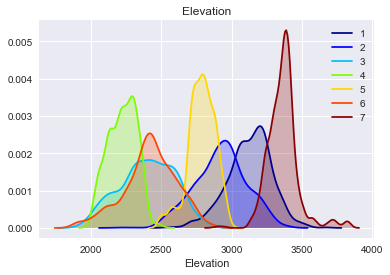

In [29]:
def density_plot(what):
    """function for density plot of 7 cover types"""

    colors = ["darkblue", "blue", "deepskyblue", "lawngreen", "gold", "orangered", "darkred"]
    labels = ["1", "2", "3", "4", "5", "6", "7"]

    for i in range(7):
        d = df_train[df_train.Cover_Type==(i+1)][what]
        sns.distplot(d, hist=False, color=colors[i], kde_kws={"shade":True}, label=labels[i])
    plt.title(what)
    plt.legend()
    plt.show()
    
density_plot("Elevation")
    

#### 5.2.3 Principal Components Analysis for KNN

Since feature scaling significantly improves the performance of KNN, to gain further insight, we perform PCA on features without and with scaling and comparing the results in 2-dimensional space.

The figure on the left shows the data points in 2D, the figure on the right shows the data points with scaling. 

The figures indicate that with feature scaling, the data points separate into more clearly defined clusters, which helps to improve the performance of the KNN classifier.

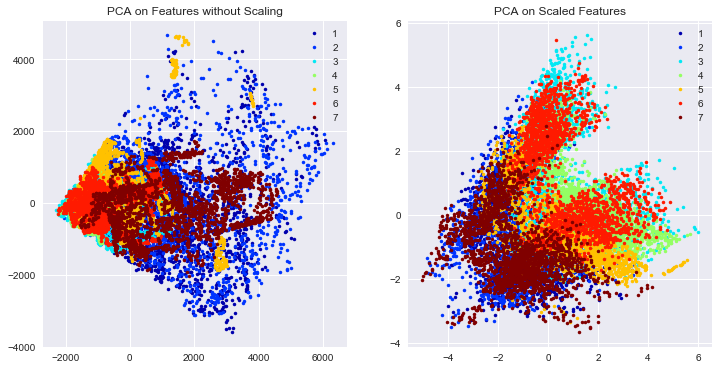

In [30]:
# STEP 1: Define PipeLines for PCA ###########################################

# function for selecting all features 
def select_all_features(X):
    return X[all_features]

# pipe1: all features without scaling
pipe_no_scaling =Pipeline(steps=[
    ('select', FunctionTransformer(select_all_features, validate=False)),
    ('pca', PCA(n_components=2))
])

# pipe2: all features with scaling to numerical features
pipe_with_scaling = Pipeline(steps=[
    ('preprocess', fu),
    ('pca', PCA(n_components=2))
])

# STEP 2: Define PCA plotting function #######################################

def plot_PCA2D(pipe, df, ax, title):
    """For plotting PCA results in 2D"""
    X2 = pipe.fit_transform(df)
    y = df.Cover_Type
    
    ax.plot(X2[y==1][:,0], X2[y==1][:,1], '.', c=cmap(10), label="1")
    ax.plot(X2[y==2][:,0], X2[y==2][:,1], '.', c=cmap(45), label="2")
    ax.plot(X2[y==3][:,0], X2[y==3][:,1], '.', c=cmap(90), label="3")
    ax.plot(X2[y==4][:,0], X2[y==4][:,1], '.', c=cmap(135), label="4")
    ax.plot(X2[y==5][:,0], X2[y==5][:,1], '.', c=cmap(180), label="5")
    ax.plot(X2[y==6][:,0], X2[y==6][:,1], '.', c=cmap(225), label="6")
    ax.plot(X2[y==7][:,0], X2[y==7][:,1], '.', c=cmap(300), label="7")
    ax.set_title(title)
    ax.legend()

# STEP 3: PCA and plotting results in 2D  ####################################

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

plot_PCA2D(pipe_no_scaling, data_train, axes[0], 'PCA on Features without Scaling')
plot_PCA2D(pipe_with_scaling, data_train, axes[1], 'PCA on Scaled Features')

### 5.3 RandomForest

In [31]:
# Base Model
# Instantiate a RandomForest object, fit to train data, produce predictions w/test data
rf = RandomForestClassifier()
rf.fit(df_train, df_train[target])

evaluate(rf, df_test, df_test[target])

Model Performance
Accuracy = 0.996%


0.9962962962962963

#### 5.3.1 Training and Test performance difference

RandomForestClassifier() has a plethora of tuning knobs to choose from. In order to quickly and efficiently identify optimal hyperparameter values, we used two different search methods.  
- RandomizedSearchCV(): used to narrow down possible hyperparameter values to an optimal *range* of values  
- GridSearchCV(): used to identify specific hyperparameter values from the ranges produced by the randomized crossvalidation search, above

We also attempted to collapse our one-hot encoded categorical variables into single categorical variables to address the following challenges that one-hot encoded categorical variables provide to tree based learning models. However, this method did not increase predictive accuracy of our model.  
- The resulting sparsity virtually ensures that continuous variables are assigned higher feature importance.  
- A single level of a categorical variable must meet a very high bar in order to be selected for splitting early in the tree building. This can degrade predictive performance.  
*source:* https://roamanalytics.com/2016/10/28/are-categorical-variables-getting-lost-in-your-random-forests/  

However, this strategy did not increase predictive accuracy. 

After leveraging the processing pipeline and using two search methods to identify the specific optimal hyperparameter values, we were able to increase our prediction accuracy by **5.4** percentage points (from **0.717** to **0.771**).

In [ ]:
# Use Randomized Cross-Validation Search to identify optimal hyperparmeter ranges

# Pre-process training data using the fu object
df_train_preprocessed = fu.fit_transform(df_train)

# num of trees
n_estimators = [int(x) for x in np.linspace(100, 500, 5)]

# num of features considered at each split
max_features = ['auto', 'sqrt', 0.5]

# max num of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, 11)]

# min num of samples required to split a node
min_samples_split = [2, 5, 10]

# min num of samples required at ea leaf node
min_samples_leaf = [1, 2, 4]

# method of selecting samples for training each tree
bootstrap = [True, False]

# create random grid
random_grid = {'n_estimators': n_estimators,
              'max_features': max_features,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
              'bootstrap': bootstrap}

# instantiate random forest model
rf = RandomForestClassifier()

# random search of hyperparams
rf_random = RandomizedSearchCV(estimator= rf, param_distributions= random_grid, n_iter = 100, cv= 3, verbose= 2, n_jobs= -1)   # didn't set random seed, so can't replicate original results

# fit the random search model
rf_random.fit(df_train_preprocessed, df_train[target])

# Show best hyperparameter settings to create ranges that will be fed into GridSearchCV()
rf_random.best_params_

In [14]:
# Conduct Cross-Validated Grid Search to find specific optimal hyperparameter settings

# Create hyperparameter grid
param_grid = {
    'bootstrap': [False],
    'max_depth': [25, 30, 35],
    'max_features': ['sqrt'],
    'min_samples_leaf': [1],
    'min_samples_split': [2, 3],
    'n_estimators': [400, 450]
}

# Instantiate randomforest object
rf = RandomForestClassifier()

# Instantiate Grid Search Object
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3,
                          n_jobs = -1, verbose = 2)

# Fit grid search model
grid_search.fit(df_train_preprocessed, df_train[target])

# save the model with optimal param settings as best_grid
best_grid = grid_search.best_estimator_

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  1.2min finished


In [15]:
# Finish defining rf pipeline using the optimal hyperparmeter settings from GridSearchCV()
rf_pipe = Pipeline(steps = [
    ('preprocess', fu),
    ('predict', best_grid)
])

# Fit the rf_pipe and Make predictions
rf_pipe.fit(data_train, data_train[target])

pred = rf_pipe.predict(data_test)

#### 5.3.2 Confusion Matrix and Error Analysis  

The cover types that are being misclassified most often are:
- predicted:1  actual: 2
- predicted:2  actual: 1
- predicted:5  actual: 2
- predicted:6  actual: 3
- predicted:7  actual: 1

Given the relative informational value of the elevation variable compared to other variables, it is logical that all of the commonly misclassified observations are for cover types that have a large elevation overlap as shown in the elevation-cover type density map, above. For instance, cover type 6 and cover type 3 nearly overlap completely in terms of elevation. Cover type 3 is commonly confused for cover type 6. Furthermore, all of the most commonly misclassified cover types also exist in the same soil conditions as demonstrated in the "Cover Types Supported By Each Soil Type" bar graph, above.

Automatically created module for IPython interactive environment


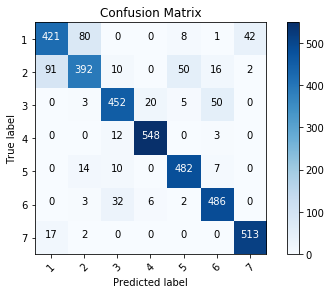

In [21]:
# Fit the rf_pipe with the train data only and make predictions on the dev data
rf_pipe.fit(df_train, df_train[target])

# Create predictions on the dev set to populate the confusion matrix
pred = rf_pipe.predict(df_test)

print(__doc__)
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(df_test[target], pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes= np.unique(df_test[target]),
                      title='Confusion Matrix')

plt.show()

## 6. Deployment

Once a model has been selected, we use all labeled data in the "train.csv" to train the model and use the trained model to make predictions for the data in "test.csv".

We then write the prediction to "test_submission.csv" and submit it to Kaggle for evaluation.



In [ ]:
# STEP 1: Train the KNN_pipe and Make predictions ######################################

selected_model = knn_pipe      # Example, when the selected model is the knn_pipe

selected_model.fit(data_train, data_train[target])  # train the selected model

pred = selected_model.predict(data_test)            # predictions for the test data
ID = data_test.Id                                   # Id for the test data


# STEP 2: Write results to csv file for Kaggle Submission #############################
data_out = []           # list for storing predictions

# populate the list with dictionaries (ID: Cover_Type)
for i in range(len(ID)):  
    data_out.append({'ID':ID.iloc[i], 'Cover_Type':pred[i]})

# write to csv    
import csv
with open('test_submission.csv', 'wt') as fout:
    cout = csv.DictWriter(fout, ['ID','Cover_Type'])
    cout.writeheader()
    cout.writerows(data_out)

## 7. Summary

Following is a performance summary of the classifiers we have tested:


|  Classifier             | Feature Eng. | Parameters       | Score on dev data | Kaggle Score  |
|:-----------------------:|:------------:|:----------------:|:-----------------:|:-------------:|
| **Logistic Regression** |          Yes | penalty='l2', C=2.0 |     0.6712     |    **0.5603** | 
| **KNN**                 |           No |    n = 2         |        0.8452     |    **0.0648** |
| **KNN**                 |          Yes |    n = 1         |        0.7933     |    **0.6906** |
| **SVM**                 |   Yes | Gaussian RBF, $\gamma=0.1$, C=1000 | 0.8116 |    **0.7223** |
| **Random Forest**       |   No |                   n_estimators=10 |            0.8680 |    **0.7177** | 
| **Random Forest**       |   Yes |                   n_estimators=400 |            0.8714 |    **0.7713** | 
| ** AdaBoost**           | Yes | depth=15, n=500, learning_rate=0.5|    0.8534 |    **0.7709** | 





## References


https://www.kaggle.com/sharmasanthosh/exploratory-study-on-feature-selection

https://www.kaggle.com/vmathur/forest-cover-eda

